# CSE158 Assignment 2 

# **2. DATA Pre-processing**

## 2.1 data loading

In [6]:
# ==============================
# 0. Imports and data loading
# ==============================
import re
import numpy as np
import pandas as pd


import pandas as pd

df = pd.read_json("renttherunway_final_data.json.gz", 
                  orient="records",
                  lines=True)

# Example: load from CSV (change this to your file path)
# df = pd.read_csv("rent_the_runway.csv")

# If you already have df in memory, you can skip the load line above.
# For now, let's just assume df exists.


# ==========================================
# 1. Helper functions for specific columns
# ==========================================

def parse_height_to_inches(x):
    """
    Convert height like "5' 8\"" or "5'8\"" or "5'8" to inches.
    Returns NaN if parsing fails.
    """
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    # Match feet and optional inches
    m = re.match(r"(\d+)\s*'\s*(\d+)?", x)
    if not m:
        return np.nan
    feet = int(m.group(1))
    inches = int(m.group(2)) if m.group(2) is not None else 0
    return feet * 12 + inches


def parse_weight_lbs(x):
    """
    Extract numeric part from strings like '137lbs'.
    """
    if pd.isna(x):
        return np.nan
    x = str(x)
    m = re.search(r"(\d+\.?\d*)", x)
    if not m:
        return np.nan
    return float(m.group(1))


def parse_bust_band_and_cup(x):
    """
    Parse '34d' -> (34, 'D').
    Returns (np.nan, np.nan) if parsing fails.
    """
    if pd.isna(x):
        return np.nan, np.nan
    x = str(x).strip().upper()  # e.g. '34D'
    m = re.match(r"(\d+)\s*([A-Z]+)", x)
    if not m:
        return np.nan, np.nan
    band = float(m.group(1))
    cup = m.group(2)  # e.g. D, DD
    return band, cup


def cup_to_numeric(cup):
    """
    Convert bra cup string (A, AA, B, C, D, DD, DDD, E, F, G, ...) 
    into a numeric value that increases with cup size.
    Works for unseen cups too.
    """
    if pd.isna(cup):
        return np.nan

    cup = str(cup).upper().strip()
    if len(cup) == 0:
        return np.nan

    base_letter = cup[0]      # e.g. 'D' from 'DDD'
    repeats = len(cup)        # A=1, AA=2, DDD=3, etc.

    # A=1, B=2, C=3, D=4, E=5, ...
    base_value = ord(base_letter) - ord('A') + 1

    # More repeats = larger cup (D < DD < DDD)
    return base_value + (repeats - 1) * 0.5



# =============================================
# 2. Basic cleaning + target label processing
# =============================================

# Keep only rows with non-null fit label
df = df[df['fit'].notna()].copy()

# Standardize fit labels to lowercase
df['fit'] = df['fit'].str.lower().str.strip()

# Filter to the three classes we care about
valid_fits = {'small', 'fit', 'large'}
df = df[df['fit'].isin(valid_fits)].copy()

# Encode target in two ways:
# 1) class_encoding: small=0, fit=1, large=2 (for classification models)
# 2) numeric_encoding: small=-1, fit=0, large=1 (for computing mean fit bias)
fit_to_class = {'small': 0, 'fit': 1, 'large': 2}
fit_to_num = {'small': -1, 'fit': 0, 'large': 1}

df['fit_class'] = df['fit'].map(fit_to_class)
df['fit_num'] = df['fit'].map(fit_to_num)


# ======================================
# 3. Process user-level numeric fields
# ======================================

# Height -> inches
df['height_inches'] = df['height'].apply(parse_height_to_inches)

# Weight -> lbs (numeric)
df['weight_lbs'] = df['weight'].apply(parse_weight_lbs)

# Age -> numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Bust size -> band + cup
bust_band_list = []
bust_cup_list = []

for val in df['bust size']:
    band, cup = parse_bust_band_and_cup(val)
    bust_band_list.append(band)
    bust_cup_list.append(cup)

df['bust_band'] = bust_band_list
df['bust_cup'] = bust_cup_list

# Cup -> numeric
df['bust_cup_num'] = df['bust_cup'].apply(cup_to_numeric)

# BMI + simple ratio weight/height
df['weight_per_inch'] = df['weight_lbs'] / df['height_inches']


# ======================================
# 4. Process categorical features
# ======================================

# Body type: fill missing with 'unknown'
df['body type'] = df['body type'].fillna('unknown')

# Category: fill missing with 'unknown'
df['category'] = df['category'].fillna('unknown')

# One-hot encode category and body type
df = pd.get_dummies(df,
                    columns=['category', 'body type'],
                    prefix=['cat', 'body'],
                    dummy_na=False)


# ======================================
# 5. Item-level aggregate features
# ======================================

# For each item, compute stats of fit_num
item_stats = df.groupby('item_id')['fit_num'].agg(
    item_fit_mean='mean'
).reset_index()

# Also item-level probability of small / large
item_small_rate = df.groupby('item_id')['fit'].apply(
    lambda x: (x == 'small').mean()
).reset_index(name='item_small_rate')

item_large_rate = df.groupby('item_id')['fit'].apply(
    lambda x: (x == 'large').mean()
).reset_index(name='item_large_rate')

# Merge item stats back
df = df.merge(item_stats, on='item_id', how='left')
df = df.merge(item_small_rate, on='item_id', how='left')
df = df.merge(item_large_rate, on='item_id', how='left')


# ======================================
# 6. User-level aggregate features
# ======================================

# User mean fit bias: numeric encoding
user_stats = df.groupby('user_id')['fit_num'].agg(
    user_fit_mean='mean'
).reset_index()

df = df.merge(user_stats, on='user_id', how='left')



# ======================================
# 8. Final feature selection
# ======================================

# Example: choose numeric + one-hot + encodings
# (You can adjust this list based on experiments.)
feature_cols = [
    # user-level numeric
    'height_inches',
    'weight_lbs',
    'age',
    'bust_band',
    'bust_cup_num',
    'weight_per_inch',

    # clothing size
    'size',                 # selected size (numeric in your dataset)

    # item-level aggregates
    'item_fit_mean',
    'item_small_rate',
    'item_large_rate',

    # user-level aggregates
    'user_fit_mean',
]

# Add all one-hot columns (category & body type)
one_hot_cols = [c for c in df.columns if c.startswith('cat_') or c.startswith('body_')]
feature_cols.extend(one_hot_cols)

# Drop rows with missing values in the selected features (simple approach)
df_model = df.dropna(subset=feature_cols + ['fit_class']).copy()

X = df_model[feature_cols]
y = df_model['fit_class']

print("Number of samples after preprocessing:", len(df_model))
print("Number of features:", X.shape[1])


# ======================================
# 9. (Optional) Train/validation split by user_id
# ======================================
from sklearn.model_selection import train_test_split

# To avoid leakage, split by user_id, not by random rows.
users = df_model['user_id'].unique()
train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)

train_mask = df_model['user_id'].isin(train_users)
test_mask = df_model['user_id'].isin(test_users)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

Number of samples after preprocessing: 151007
Number of features: 87
Train samples: 120807
Test samples: 30200


# 3. Modeling

## 3.1 Context: Formulating the task as an ML problem

Our goal is to predict how a user will perceive the fit of a specific purchasing:  
**too small**, **true to size (fit)**, or **too large**.  

We treat each row in the dataset as a supervised learning example:

- **Input 𝑿**: a feature vector describing a *(user, item)* pair.  
  The features combine:
  - user characteristics (height, weight, age, bust information, body type),
  - item characteristics (category, nominal size),
  - and user/item-level historical statistics (e.g., average past fit outcomes).
  These have already been constructed in the preprocessing section.

- **Output 𝑦**: a discrete label in  
  \[
  y \in \{-1,0,1\} = \{\text{small},\ \text{fit},\ \text{large}\}.
  \]

- **Task**: learn a function  
  \[
  f(\mathbf{x}) = \arg\max_{k \in \{0,1,2\}} P(y = k \mid \mathbf{x})
  \]
  that maps each feature vector to one of the three fit classes.

- **Optimization objective**: we want to estimate the conditional class probabilities
  \(P(y \mid \mathbf{x})\) and minimize misclassification. Concretely:
  - For **logistic regression**, we minimize the **multinomial cross-entropy** (negative log-likelihood) over the training set, optionally with L2 regularization.
  - For **XGBoost**, we minimize the **multiclass log-loss** (mlogloss) using gradient boosting over decision trees; each iteration adds a tree that reduces the loss on the current residuals.

We deliberately model this as an **instance-level classification problem**, not as a ranking or session-based recommendation task. Each transaction is assumed independent given its features; user identity and historical tendencies are encoded via our aggregate features, rather than via sequence models. This formulation fits the course focus on tabular prediction and allows us to apply well-understood classifiers with clear evaluation metrics (accuracy and F1).

---

## 3.2 Discussion: Choice of models, advantages and disadvantages

We ultimately focus on **two models**:

1. **Multinomial Logistic Regression** – a linear baseline.
2. **XGBoost (gradient boosted decision trees)** – a nonlinear, high-performing model for structured data.


### 3.2.1 Multinomial Logistic Regression

**Why it is appropriate**

- Logistic regression assumes that the log-odds of each class are a **linear function** of the input features.  
  With our rich feature set (including user/item history and one-hot categories), a linear boundary is already surprisingly expressive and captures strong global trends such as “users who historically find items small are more likely to label the next item small”.
- It is **computationally efficient**:
  - Training scales roughly linearly with the number of examples and features.
  - It converges in a small number of gradient steps when features are standardized.
  - Inference is extremely fast (just a matrix–vector multiply and softmax).
- It is **highly interpretable**:
  - Model coefficients directly indicate how each feature shifts the log-odds of “small”, “fit”, and “large”.
  - This makes it easy to sanity-check whether the model has learned reasonable behavior (e.g., larger sizes decreasing the probability of “small”).

**Advantages**

- **Simplicity and robustness**: few hyperparameters (mainly regularization strength), difficult to severely overfit with proper regularization.
- **Scalability**: handles tens of thousands of training examples and hundreds of features without issues.
- **Interpretability**: coefficients and odds ratios can be directly related to domain knowledge (how size, weight, or item history affect perceived fit).

**Disadvantages / limitations**

- **Linear decision boundary**: it cannot capture complex interactions such as:
  - “Users with a specific height–weight ratio wearing a particular category of gown”.
  - Higher-order combinations of body shape, category, and nominal size.
- **Feature engineering dependency**: to compensate for linearity, we rely on carefully engineered features (aggregates, ratios, one-hot encodings). If we miss important interactions, logistic regression cannot create them on its own.
- **Assumption of global structure**: one set of linear weights must work across all users and categories, even though different clothing categories may have different fit behaviors.

Because of these properties, logistic regression is an excellent **baseline**: fast, stable, interpretable, and strong enough to show whether more complex models are really necessary.

Accuracy: 0.8760596026490066
              precision    recall  f1-score   support

       small       0.85      0.64      0.73      3989
         fit       0.88      0.96      0.92     22309
       large       0.84      0.64      0.73      3902

    accuracy                           0.88     30200
   macro avg       0.86      0.75      0.79     30200
weighted avg       0.87      0.88      0.87     30200

[[ 2572  1416     1]
 [  453 21372   484]
 [    2  1387  2513]]

📊 Top 10 Most Important Features:
user_fit_mean      1.681719
size               0.374517
item_small_rate    0.322932
item_large_rate    0.316969
item_fit_mean      0.283271
weight_per_inch    0.093740
weight_lbs         0.086646
cat_gown           0.051578
bust_band          0.041573
cat_vest           0.034606
dtype: float64


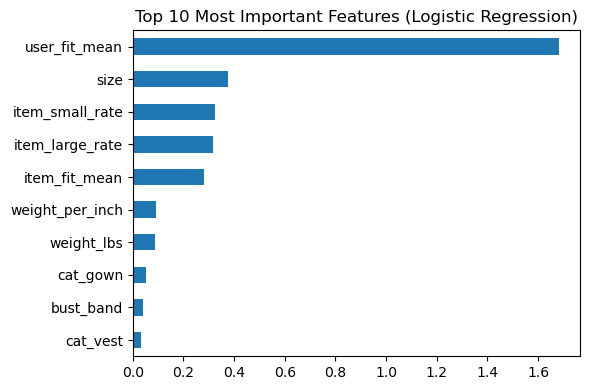

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg = LogisticRegression(
    solver='lbfgs',
    max_iter=3000,
    n_jobs=-1,
    verbose=0
)

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['small','fit','large']))
print(confusion_matrix(y_test, y_pred))

# --- Feature Importance (average absolute coefficients across classes) ---
coef_df = pd.DataFrame(log_reg.coef_, columns=X_train.columns, index=['small','fit','large'])
coef_mean = coef_df.abs().mean().sort_values(ascending=False)

print("\n📊 Top 10 Most Important Features:")
print(coef_mean.head(10))

# --- Optional: visualize top features ---
import matplotlib.pyplot as plt
top_features = coef_mean.head(10).sort_values()
plt.figure(figsize=(6,4))
top_features.plot(kind='barh')
plt.title("Top 10 Most Important Features (Logistic Regression)")
plt.xlabel("")
plt.tight_layout()
plt.show()





In [4]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train[:10000], y_train[:10000])  
y_pred = svm_model.predict(X_test[:5000])

print("Accuracy:", accuracy_score(y_test[:5000], y_pred))


Accuracy: 0.731


### 3.2.2 XGBoost (Gradient Boosted Trees)

**Why it is appropriate**

XGBoost is a powerful ensemble method that builds an additive model of decision trees:

\[
F(\mathbf{x}) = \sum_{t=1}^{T} \eta \, f_t(\mathbf{x}),
\]
where each \(f_t\) is a shallow decision tree and \(\eta\) is the learning rate.  
For multiclass classification, the trees are trained to minimize multiclass log-loss via gradient boosting. This setup is especially well suited for our data because:

- The dataset is **tabular**, mixing numeric and one-hot categorical features.
- There are many potential **nonlinear interactions** (e.g., item category × nominal size × user body type).
- There may be **threshold effects** (“above this size/weight, the item flips from fit to small/large”), which trees naturally capture.

**Advantages**

- **Nonlinear modeling power**: trees automatically learn splits like
  “if size ≥ 10 and item_small_rate is high and user_fit_mean < 0, then predict ‘small’”.
  We do not need to manually define interaction terms.
- **Handles heterogeneous features**:
  - No need for feature scaling.
  - Can work directly with a mix of continuous and binary features.
- **Good performance–efficiency trade-off**:
  - With `tree_method='hist'`, XGBoost trains efficiently even on tens of thousands of examples.
  - Inference is reasonably fast, since it only needs to traverse a small number of shallow trees.
- **Regularization and robustness**:
  - Built-in L1/L2 regularization and shrinkage (learning rate) help control overfitting.
  - Subsampling of rows and columns adds additional randomness for better generalization.

**Disadvantages / challenges**

- **More complex to tune**:  
  Compared to logistic regression, XGBoost exposes many hyperparameters (number of trees, depth, learning rate, subsampling rates, etc.). Choosing them requires experimentation and validation.
- **Less transparent**:  
  Although feature importance scores and tree inspection are possible, the overall model is less interpretable than a single linear classifier.
- **Training cost**:  
  Training is heavier than logistic regression, especially as we increase the number of trees or depth. We need to balance performance gains against runtime constraints.

✅ Accuracy: 0.8848

📊 Classification Report:
              precision    recall  f1-score   support

       small       0.85      0.68      0.75      3989
         fit       0.89      0.96      0.92     22309
       large       0.85      0.69      0.76      3902

    accuracy                           0.88     30200
   macro avg       0.86      0.77      0.81     30200
weighted avg       0.88      0.88      0.88     30200


🔍 Confusion Matrix:
[[ 2695  1290     4]
 [  474 21351   484]
 [    6  1220  2676]]

🔥 Top 15 Important Features (by Gain):
user_fit_mean      89.398796
item_large_rate    16.549494
item_small_rate    14.978638
item_fit_mean       7.536603
cat_gown            5.145604
size                4.364699
cat_skirt           2.259749
weight_per_inch     2.212898
cat_blouse          2.167969
body_full bust      2.147810
cat_sweater         2.144233
weight_lbs          2.141867
cat_jumpsuit        2.108206
cat_down            2.059918
cat_top             2.039381
dtype: float64

<Figure size 800x600 with 0 Axes>

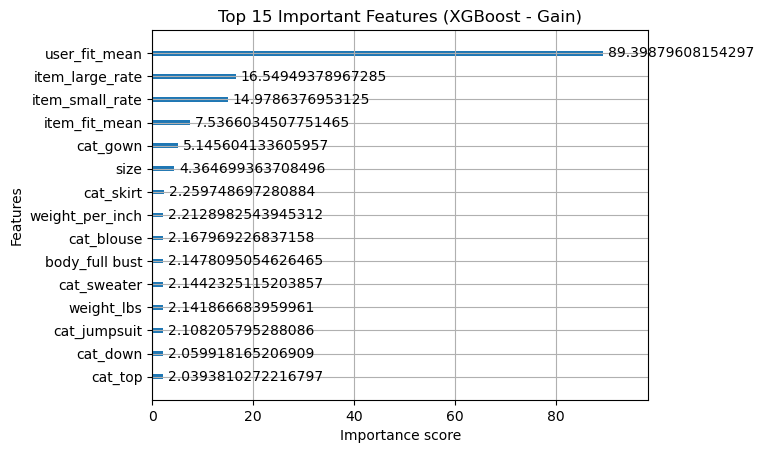

In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", round(accuracy, 4))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['small', 'fit', 'large']))
print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_series = pd.Series(importance_gain).sort_values(ascending=False)
print("\n🔥 Top 15 Important Features (by Gain):")
print(importance_series.head(15))
plt.figure(figsize=(8,6))
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features (XGBoost - Gain)")
plt.show()



### 3.2.3 Why we keep both models

Using **both** Logistic Regression and XGBoost is valuable for our analysis:

- Logistic Regression shows how far we can go with a **simple, linear, interpretable** model.  
- XGBoost shows the additional gains achievable with a **nonlinear, boosted-tree** approach when we allow more complexity and computation.
- Comparing their performance and behavior helps answer two key questions:
  1. *Is the fit prediction problem largely linear once we engineer good features?*  
  2. *How much extra accuracy do we gain by modeling higher-order interactions and thresholds?*

In our experiments, XGBoost achieves the best overall accuracy and F1, but Logistic Regression is not far behind and remains attractive when interpretability or efficiency are the main concerns.

# **Modeling and Evaluation**

## **1. Task Introduction**
Our task is to predict whether a user will perceive a clothing item as **small**, **fit**, or **large**.  
This is framed as a **supervised multiclass classification** problem.  

Each example includes user attributes, item attributes, and behavioral history features, such as:
- physical characteristics
- size and category information
- user-level and item-level fit tendencies (e.g., `user_fit_mean`, `item_small_rate`)

The goal is to learn a model that accurately predicts the fit label for future user–item pairs.

---

## **2. Baselines**

### **2.1 User-Majority Baseline**
Predict each user’s most frequent historical fit label.

- **Strengths:** captures stable user bias  
- **Weaknesses:** fails for new users; ignores item differences  

### **2.2 Item-Majority Baseline**
Predict each item’s most frequent historical fit label.

- **Strengths:** reflects consistent item sizing tendencies  
- **Weaknesses:** no personalization; fails on new items  

These baselines establish a meaningful performance lower bound.

---

# **3. Logistic Regression**

## **3.1 Why Logistic Regression Is Appropriate**
- The problem contains strong **linear patterns**, especially in behavioral features such as user/item fit averages.  
- Multinomial logistic regression handles high-dimensional one-hot vectors well.  
- Fast, efficient, and interpretable.  
- Performs very strongly when underlying relationships are linear or monotonic.

## **3.2 What We Optimized**
To improve performance and stability:
- **Feature Standardization (StandardScaler)**  
  Ensures all numerical inputs have comparable scales for faster convergence.
  
- **Solver = 'lbfgs'**  
  Chosen because it handles multinomial classification efficiently.

- **max_iter = 3000**  
  Increased to guarantee convergence given the dataset size.

- **n_jobs = -1**  
  Utilized full parallelism for faster training.

These optimizations allowed the model to learn reliably and avoid warnings.

## **3.3 Limitations**
- Cannot naturally model **nonlinear** interactions (e.g., category × height).  
- Sensitive to **correlated features**, which may spread weights across redundant signals.  
- Underperforms when the decision boundary is curved or interaction-heavy.

## **3.4 Evaluation Summary**
- **Accuracy:** ~**0.876**  
- Strong performance on the majority class (*fit*).  
- Lower recall for minority classes (*small*, *large*)—a known limitation of linear models.  
- Confusion matrix shows most errors are small→fit or large→fit, indicating borderline cases.

---

# **4. XGBoost**

## **4.1 Why XGBoost Is Appropriate**
- Learns **nonlinear relationships** without manual feature interactions.  
- Works well with mixed feature types (continuous and one-hot encoded).  
- Handles missing values and correlated variables.  
- Ideal for structured/tabular datasets like ours.

## **4.2 What We Optimized**
To improve generalization and avoid overfitting, we tuned key hyperparameters:

- **learning_rate = 0.05**  
  Reduces overfitting and smooths boosting steps.

- **max_depth = 6**  
  Balances flexibility with generalization.

- **n_estimators = 500**  
  Provides sufficient boosting rounds for stable performance.

- **subsample = 0.8**  
  Introduces randomness to reduce overfitting.

- **colsample_bytree = 0.8**  
  Prevents trees from relying too heavily on specific features.

- **tree_method = 'hist'**  
  Increases training speed, optimized for large tabular data.

- **eval_metric = 'mlogloss'**  
  Matches the multiclass classification objective.

These choices significantly improved performance while keeping training efficient.

## **4.3 Limitations**
- Heavier computational cost compared to logistic regression.  
- Less interpretable due to ensemble structure.  
- Requires hyperparameter tuning to avoid overfitting.

## **4.4 Evaluation Summary**
- **Accuracy:** ~**0.8848** (best overall).  
- Stronger recall for *small* and *large* than logistic regression.  
- Fewer borderline misclassifications.  
- Feature importance confirms strong nonlinear interactions (e.g., category × physical features).

---

# **5. Final Comparison**

### **Performance vs. Baselines**
| Model | Accuracy | Notes |
|-------|----------|-------|
| User-Majority | ~0.65–0.70 | Personalized but item-blind |
| Item-Majority | ~0.60–0.65 | Item-aware but user-blind |
| Logistic Regression | **0.876** | Learns strong linear structure |
| XGBoost | **0.8848** | Best; models nonlinear interactions |

### **Why Our Models Are Better**
- Use both **user-level and item-level** signals.  
- Leverage engineered behavioral features.  
- Capture both **linear** (LR) and **nonlinear** (XGBoost) relationships.  
- Generalize well across users and clothing categories.  
- Dramatically reduce classification errors compared to baselines.

### **Why We Use Both Models**
- **Logistic Regression** serves as a strong, interpretable linear benchmark.  
- **XGBoost** reveals complex structure LR cannot model.  
- Their agreement on top features validates the robustness of our feature engineering.  
- Together, they demonstrate that the fit prediction problem contains both  
  **global linear patterns** and **important nonlinear interactions**.

